Create a tool to analyze sentiment for products based on Twitter posts, to be used by companies to monitor public perception of their products. 

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from keras import metrics
import tensorflow as tf
from tensorflow.keras import backend as K

from nltk.corpus import stopwords
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import nltk
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mleroi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mleroi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [121]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [122]:
df.dropna(subset=['tweet_text'], inplace=True)
df.drop_duplicates(subset=['tweet_text'], inplace=True)
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [123]:
pos_neg_df = df[(df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion') | (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion')]

In [124]:
pos_neg_tweets = pos_neg_df['tweet_text']

In [125]:
pos_neg_sentiment = pos_neg_df['is_there_an_emotion_directed_at_a_brand_or_product'].copy()

In [126]:
sentiment_count = pos_neg_sentiment.value_counts()
print(f'Sentiment count: \n{sentiment_count}')
print(f'Positive: {round(sentiment_count[0]/sum(sentiment_count)*100,1)}%')

Sentiment count: 
Positive emotion    2968
Negative emotion     569
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64
Positive: 83.9%


In [127]:
X_train, X_test, y_train, y_test = train_test_split(pos_neg_tweets,pos_neg_sentiment, 
                                                    test_size=0.15, 
                                                    random_state=42, 
                                                    stratify=pos_neg_sentiment)
# X_val = X_train[-int(len(X_train) * 0.2):]
# y_val = y_train[-int(len(y_train) * 0.2):]

In [128]:
def f1_macro(y_true, y_pred):
    """
    Multiclass F1 Score (macro average) for Keras.
    Works with sparse categorical crossentropy labels.
    """
    # Convert y_true to one-hot
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    
    # Binarize predictions
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=tf.shape(y_pred)[-1])
    
    # True positives, false positives, false negatives
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, "float"), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, "float"), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), "float"), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
  
    # Macro average (mean across classes)
    return tf.reduce_mean(f1)

In [129]:
def run_pipe(X,y, num_words=2000, 
             remove_stopwords=False, 
             lemmatize=False, 
             num_epochs=200, 
             show_results=False, 
             balance_classes=False):

    # Compute weights to balance positive and negative comments to combat data imbalance
    classes = np.unique(y)
    class_weights = [1]*len(classes)
    if balance_classes:
        class_weights = compute_class_weight(
            class_weight="balanced",
            classes=classes,
            y=y)
        if len(classes) == 3:
            class_weights=[1/.15,1/.6,1/.4]

    class_weights = dict(zip(classes,class_weights))

    # ---------------------------
    # Step 1: Custom text prep transformer
    # ---------------------------

    class TextPrep(BaseEstimator, TransformerMixin):
        def __init__(self):
            self.remove_stopwords = remove_stopwords
            self.lemmatize = lemmatize
            self.stop_words = set(stopwords.words("english"))
            self.lemmatizer = WordNetLemmatizer()

        def get_wordnet_pos(self, treebank_tag):
            """Map POS tag to WordNet format for better lemmatization"""
            if treebank_tag.startswith("J"):
                return wordnet.ADJ
            elif treebank_tag.startswith("V"):
                return wordnet.VERB
            elif treebank_tag.startswith("N"):
                return wordnet.NOUN
            elif treebank_tag.startswith("R"):
                return wordnet.ADV
            else:
                return wordnet.NOUN  # fallback

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            if isinstance(X, np.ndarray):
                X = X.ravel()
            X = [str(x) for x in X]

            processed = []
            for text in X:
                words = word_tokenize(text)

                # Remove stopwords if enabled
                if self.remove_stopwords:
                    words = [w for w in words if w.lower() not in self.stop_words]

                # Lemmatization if enabled
                if self.lemmatize:
                    pos_tags = pos_tag(words)
                    words = [self.lemmatizer.lemmatize(w, self.get_wordnet_pos(tag)) 
                             for w, tag in pos_tags]
                processed.append(" ".join(words))

            return processed        
        
    # ---------------------------
    # Step 2: Wrap tokenizer
    # ---------------------------
    class KerasTokenizer(BaseEstimator, TransformerMixin):
        def __init__(self, mode="binary"):
            self.num_words = num_words
            self.mode = mode
            self.tokenizer = Tokenizer(num_words=self.num_words)

        def fit(self, X, y=None):
            self.tokenizer.fit_on_texts(X)
            return self

        def transform(self, X):
            return self.tokenizer.texts_to_matrix(X, mode=self.mode)    
      
    # ---------------------------
    # Step 3: Build model
    # ---------------------------
    def build_model(input_dim, n_classes):
        model = Sequential()
        model.add(Dense(50, activation="relu", input_shape=(input_dim,)))
        model.add(Dense(25, activation="relu"))
        model.add(Dense(n_classes, activation="softmax"))
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=['accuracy'],
            weighted_metrics=[]
        )
        return model

    # ---------------------------
    # Step 4: Setup pipeline
    # ---------------------------
    n_classes = len(np.unique(y))

    pipeline = Pipeline([
        ("prep", TextPrep()),
        ("tok", KerasTokenizer()),
        ("clf", KerasClassifier(
            build_fn=lambda: build_model(
                input_dim=pipeline.named_steps["tok"].num_words, 
                n_classes=n_classes),
            epochs=num_epochs,
            batch_size=256,
            verbose=0,
            validation_split=0.2, 
            callbacks=[EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True)],
            class_weight=class_weights)
        )
    ])
    
    # ---------------------------
    # Step 5: Fit
    # ---------------------------
    pipeline.fit(X, y)
        
    # ---------------------------
    # Step 6: Test results
    # ---------------------------   
    
    # Access history directly (no `.history`)
    pipe_history = pipeline.named_steps["clf"].history_

#     test_acc = pipeline.score(X_test, y_test)
#     print("Test Accuracy:", test_acc)

    X_val = X[-int(len(X) * 0.2):]
    y_val = y[-int(len(y) * 0.2):]

    # Get predictions and F1 score
    y_pred = pipeline.predict(X_val)
    pipe_f1 = f1_score(y_val, y_pred, average='weighted')
#     print(y_val.value_counts())
#     print('\nPredictions:')
#     display(pd.DataFrame(y_pred).value_counts())

    # Detailed classification report
#     print(classification_report(y_test, y_pred))
    
    if show_results:
        # Confusion matrix
        print(confusion_matrix(y_val, y_pred))
        # Plot accuracy
        print("Max Val Accuracy:", max(pipe_history["val_accuracy"]), accuracy_score(y_val, y_pred))
        print("F1 score: ", pipe_f1)
        plt.figure(figsize=(8,5))
        plt.plot(pipe_history["accuracy"], label="Train Accuracy")
        if "val_accuracy" in pipe_history:
            plt.plot(pipe_history["val_accuracy"], label="Validation Accuracy")
        plt.title("Epoch vs Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
    
    return max(pipe_history["val_accuracy"]), pipe_f1;

In [130]:
def parameter_check (X_par, y_par, num_words_list, plot=True, balance_classes=False, show_results=False):
    
    results=pd.DataFrame(columns=["number_of_words","val_accuracy", 'remove_stopwords', 'lemmatize', 'f1'])
    i=1
    stop_tf=False
    lem_tf=False
    for j in range(3):
        for x in num_words_list:
            for stop_tf in [False,True]:
                for lem_tf in [False,True]:
                    acc, f1=run_pipe(X_par,y_par, 
                                     num_words=x,
                                     remove_stopwords=stop_tf, 
                                     lemmatize=lem_tf, 
                                     balance_classes=balance_classes, 
                                     show_results=show_results)

                    print(f'({i} of {len(num_words_list)*4}) Stopwords: {stop_tf}, Lemmatize: {lem_tf}, Number of words: {x}, Val accuracy: {round(acc,4)}, F1 score: {round(f1,4)}')
                    new_row_data = {'number_of_words': [x], 'val_accuracy': [acc], 'remove_stopwords': [stop_tf], 'lemmatize': [lem_tf], 'f1': [f1]}
                    new_row = pd.DataFrame(new_row_data)
                    results = pd.concat([results,new_row], ignore_index=True)
                    i += 1
        results["config"] = results.apply(
            lambda row: f"Stopwords={row['remove_stopwords']}, Lemmatize={row['lemmatize']}", axis=1
        )

        results = results.sort_values("number_of_words")

    if plot:
        fig, ax1 = plt.subplots(figsize=(10,6))
        sns.lineplot(
            data=results,
            x="number_of_words",
            y="val_accuracy",
            hue="config",
            style="config",
            ax=ax1,
            markers=True,
#             estimator=None,
            dashes=False)
        
        plt.title("Validation Accuracy vs Number of Words", fontsize=14)
        plt.xlabel("Number of Words", fontsize=12)
        plt.ylabel("Validation Accuracy", fontsize=12)
        plt.legend(title="Preprocessing Config")
        plt.grid(True, alpha=0.3)
        plt.show()
        
        fig, ax2 = plt.subplots(figsize=(10,6))
        
        sns.lineplot(
            data=results,
            x="number_of_words",
            y="f1",
            hue="config",
            style="config",
            ax=ax2,
            markers=True,
            dashes=True)
        plt.title("Validation F1 Score vs Number of Words", fontsize=14)
        plt.xlabel("Number of Words", fontsize=12)
        plt.ylabel("Validation F1 Score", fontsize=12)
        plt.legend(title="Preprocessing Config")
        plt.grid(True, alpha=0.3)
        plt.show()
        
    return results

In [131]:
sentiment_count = y_test.value_counts()
print(f'Sentiment count: \n{sentiment_count}')
sentiment_count[0]/sum(sentiment_count)

Sentiment count: 
Positive emotion    446
Negative emotion     85
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


0.839924670433145

(1 of 20) Stopwords: False, Lemmatize: False, Number of words: 300, Val accuracy: 0.8355, F1 score: 0.7626
(2 of 20) Stopwords: False, Lemmatize: True, Number of words: 300, Val accuracy: 0.8355, F1 score: 0.7626
(3 of 20) Stopwords: True, Lemmatize: False, Number of words: 300, Val accuracy: 0.8571, F1 score: 0.832
(4 of 20) Stopwords: True, Lemmatize: True, Number of words: 300, Val accuracy: 0.8355, F1 score: 0.7626
(5 of 20) Stopwords: False, Lemmatize: False, Number of words: 1000, Val accuracy: 0.8804, F1 score: 0.8608
(6 of 20) Stopwords: False, Lemmatize: True, Number of words: 1000, Val accuracy: 0.8854, F1 score: 0.8768
(7 of 20) Stopwords: True, Lemmatize: False, Number of words: 1000, Val accuracy: 0.8654, F1 score: 0.8294
(8 of 20) Stopwords: True, Lemmatize: True, Number of words: 1000, Val accuracy: 0.8887, F1 score: 0.8797
(9 of 20) Stopwords: False, Lemmatize: False, Number of words: 2000, Val accuracy: 0.8787, F1 score: 0.8571
(10 of 20) Stopwords: False, Lemmatize: T

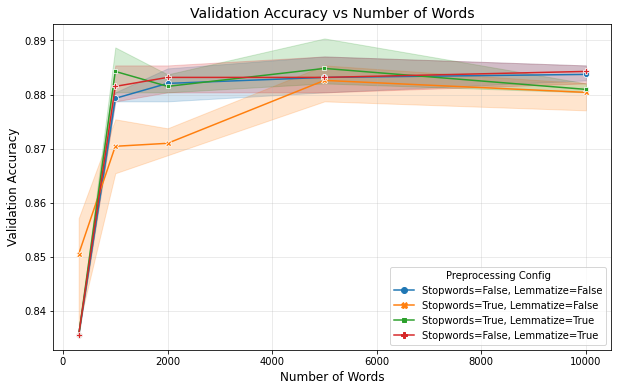

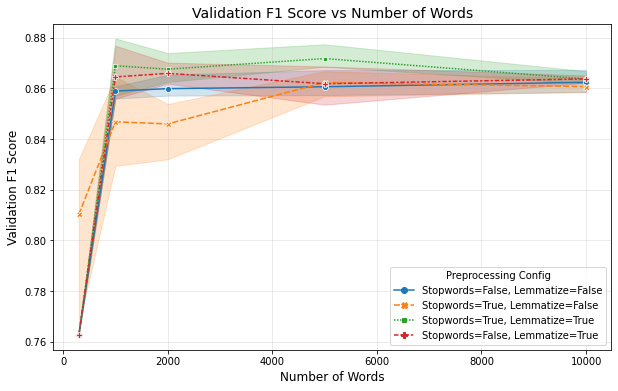

In [132]:
num_words_list = [300, 1000, 2000, 5000, 10000]
results = parameter_check(X_train,y_train, num_words_list, show_results=False)

In [133]:
display(results)

,number_of_words,val_accuracy,remove_stopwords,lemmatize,f1,config
0,300,0.835548,False,False,0.762645,"Stopwords=False, Lemmatize=False"
42,300,0.857143,True,False,0.832059,"Stopwords=True, Lemmatize=False"
43,300,0.835548,True,True,0.762645,"Stopwords=True, Lemmatize=True"
41,300,0.835548,False,True,0.762645,"Stopwords=False, Lemmatize=True"
7,300,0.835548,True,True,0.762645,"Stopwords=True, Lemmatize=True"
6,300,0.857143,True,False,0.832033,"Stopwords=True, Lemmatize=False"
40,300,0.835548,False,False,0.762645,"Stopwords=False, Lemmatize=False"
4,300,0.835548,True,True,0.762645,"Stopwords=True, Lemmatize=True"
5,300,0.835548,False,True,0.762645,"Stopwords=False, Lemmatize=True"
3,300,0.837209,True,False,0.766631,"Stopwords=True, Lemmatize=False"


(1 of 20) Stopwords: False, Lemmatize: False, Number of words: 300, Val accuracy: 0.8571, F1 score: 0.8278
(2 of 20) Stopwords: False, Lemmatize: True, Number of words: 300, Val accuracy: 0.8571, F1 score: 0.832
(3 of 20) Stopwords: True, Lemmatize: False, Number of words: 300, Val accuracy: 0.8355, F1 score: 0.7626
(4 of 20) Stopwords: True, Lemmatize: True, Number of words: 300, Val accuracy: 0.8355, F1 score: 0.7626
(5 of 20) Stopwords: False, Lemmatize: False, Number of words: 1000, Val accuracy: 0.8837, F1 score: 0.8668
(6 of 20) Stopwords: False, Lemmatize: True, Number of words: 1000, Val accuracy: 0.8771, F1 score: 0.858
(7 of 20) Stopwords: True, Lemmatize: False, Number of words: 1000, Val accuracy: 0.8754, F1 score: 0.8629
(8 of 20) Stopwords: True, Lemmatize: True, Number of words: 1000, Val accuracy: 0.8821, F1 score: 0.871
(9 of 20) Stopwords: False, Lemmatize: False, Number of words: 2000, Val accuracy: 0.8804, F1 score: 0.856
(10 of 20) Stopwords: False, Lemmatize: True

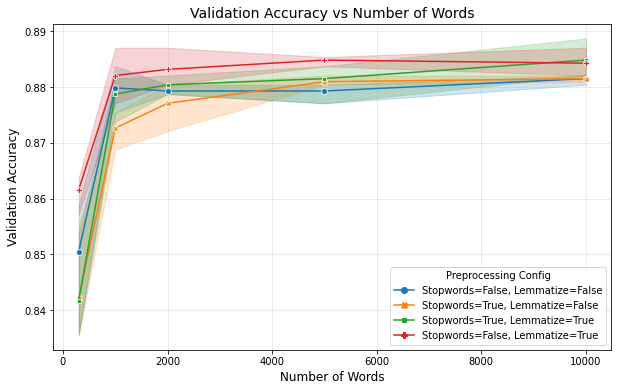

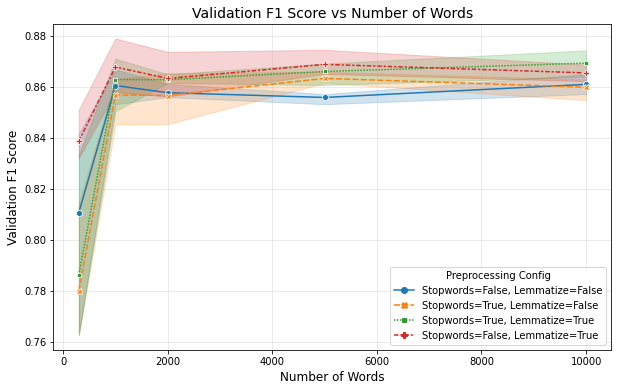

,number_of_words,val_accuracy,remove_stopwords,lemmatize,f1,config
0,300,0.857143,False,False,0.827773,"Stopwords=False, Lemmatize=False"
42,300,0.835548,True,False,0.762645,"Stopwords=True, Lemmatize=False"
43,300,0.835548,True,True,0.762645,"Stopwords=True, Lemmatize=True"
41,300,0.863787,False,True,0.832938,"Stopwords=False, Lemmatize=True"
7,300,0.835548,True,True,0.762645,"Stopwords=True, Lemmatize=True"
6,300,0.835548,True,False,0.762645,"Stopwords=True, Lemmatize=False"
40,300,0.858804,False,False,0.841593,"Stopwords=False, Lemmatize=False"
4,300,0.853821,True,True,0.833276,"Stopwords=True, Lemmatize=True"
5,300,0.857143,False,True,0.832033,"Stopwords=False, Lemmatize=True"
3,300,0.855482,True,False,0.814759,"Stopwords=True, Lemmatize=False"


In [134]:
num_words_list = [300, 1000, 2000, 5000, 10000]
results = parameter_check(X_train,y_train, num_words_list, show_results=False)
display(results)

### add another preprocessing step? There was somethng i was thinking about that i can't remember now
Add step to artificially increase negative comments. can't remember the name for it. Unbalanced data?

(1 of 20) Stopwords: False, Lemmatize: False, Number of words: 300, Val accuracy: 0.8538, F1 score: 0.849
(2 of 20) Stopwords: False, Lemmatize: True, Number of words: 300, Val accuracy: 0.8505, F1 score: 0.852
(3 of 20) Stopwords: True, Lemmatize: False, Number of words: 300, Val accuracy: 0.7625, F1 score: 0.7595
(4 of 20) Stopwords: True, Lemmatize: True, Number of words: 300, Val accuracy: 0.8322, F1 score: 0.8336
(5 of 20) Stopwords: False, Lemmatize: False, Number of words: 1000, Val accuracy: 0.8605, F1 score: 0.8572
(6 of 20) Stopwords: False, Lemmatize: True, Number of words: 1000, Val accuracy: 0.8472, F1 score: 0.8509
(7 of 20) Stopwords: True, Lemmatize: False, Number of words: 1000, Val accuracy: 0.8522, F1 score: 0.8497
(8 of 20) Stopwords: True, Lemmatize: True, Number of words: 1000, Val accuracy: 0.8671, F1 score: 0.8663
(9 of 20) Stopwords: False, Lemmatize: False, Number of words: 2000, Val accuracy: 0.8621, F1 score: 0.8658
(10 of 20) Stopwords: False, Lemmatize: Tr

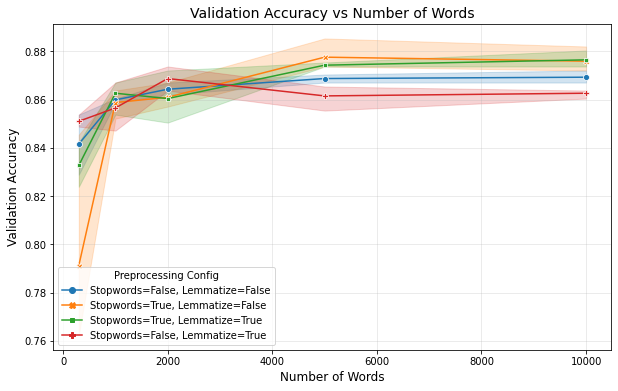

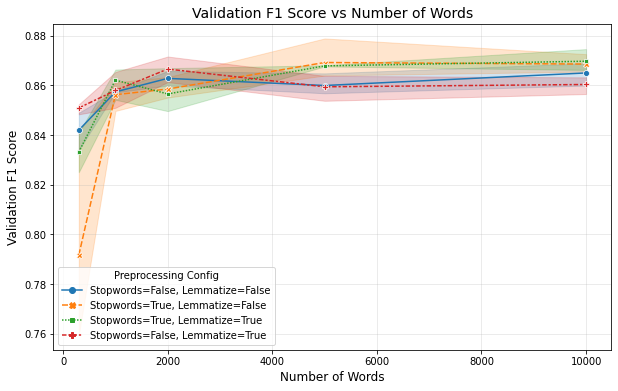

In [135]:
num_words_list = [300, 1000, 2000, 5000, 10000]
results = parameter_check(X_train,y_train, num_words_list, balance_classes=True, show_results=False)

In [136]:
results

,number_of_words,val_accuracy,remove_stopwords,lemmatize,f1,config
0,300,0.853821,False,False,0.848951,"Stopwords=False, Lemmatize=False"
42,300,0.765781,True,False,0.773963,"Stopwords=True, Lemmatize=False"
43,300,0.842193,True,True,0.840937,"Stopwords=True, Lemmatize=True"
41,300,0.853821,False,True,0.852342,"Stopwords=False, Lemmatize=True"
7,300,0.832226,True,True,0.833617,"Stopwords=True, Lemmatize=True"
6,300,0.762458,True,False,0.759537,"Stopwords=True, Lemmatize=False"
40,300,0.842193,False,False,0.842885,"Stopwords=False, Lemmatize=False"
4,300,0.823920,True,True,0.825039,"Stopwords=True, Lemmatize=True"
5,300,0.850498,False,True,0.852024,"Stopwords=False, Lemmatize=True"
3,300,0.845515,True,False,0.841494,"Stopwords=True, Lemmatize=False"


In [137]:
# run_pipe(X_train,y_train, num_words=500, num_epochs=300, remove_stopwords=False, lemmatize=True)

# don't use X_test, y_test in final version. print val results

### add neutral/can't tell

In [138]:
rand_df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"].sample(frac=1, random_state=42).reset_index(drop=True)

In [139]:
rand_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [140]:
tweets = rand_df['tweet_text']
sentiment = rand_df['is_there_an_emotion_directed_at_a_brand_or_product'].copy()

In [141]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(tweets,sentiment, test_size=0.15, random_state=7, stratify=sentiment)
# X_val_all = X_train_all[-int(len(X_train_all) * 0.2):]
# y_val_all = y_train_all[-int(len(y_train_all) * 0.2):]

In [142]:
round(sentiment.value_counts()/len(sentiment)*100,1)

No emotion toward brand or product    60.3
Positive emotion                      33.3
Negative emotion                       6.4
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [143]:
round(y_train_all.value_counts()/len(y_train_all)*100,1)

No emotion toward brand or product    60.3
Positive emotion                      33.3
Negative emotion                       6.4
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [144]:
round(y_test_all.value_counts()/len(y_test_all)*100,1)

No emotion toward brand or product    60.3
Positive emotion                      33.4
Negative emotion                       6.4
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [145]:
y_val_all = y_train_all[-int(len(y_train_all) * 0.2):]
round(y_val_all.value_counts()/len(y_val_all)*100,1)

No emotion toward brand or product    61.4
Positive emotion                      31.8
Negative emotion                       6.7
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

(1 of 20) Stopwords: False, Lemmatize: False, Number of words: 300, Val accuracy: 0.6554, F1 score: 0.6162
(2 of 20) Stopwords: False, Lemmatize: True, Number of words: 300, Val accuracy: 0.6574, F1 score: 0.6167
(3 of 20) Stopwords: True, Lemmatize: False, Number of words: 300, Val accuracy: 0.6587, F1 score: 0.6067
(4 of 20) Stopwords: True, Lemmatize: True, Number of words: 300, Val accuracy: 0.6495, F1 score: 0.6148
(5 of 20) Stopwords: False, Lemmatize: False, Number of words: 1000, Val accuracy: 0.6739, F1 score: 0.6436
(6 of 20) Stopwords: False, Lemmatize: True, Number of words: 1000, Val accuracy: 0.6733, F1 score: 0.6592
(7 of 20) Stopwords: True, Lemmatize: False, Number of words: 1000, Val accuracy: 0.6634, F1 score: 0.647
(8 of 20) Stopwords: True, Lemmatize: True, Number of words: 1000, Val accuracy: 0.6719, F1 score: 0.6531
(9 of 20) Stopwords: False, Lemmatize: False, Number of words: 2000, Val accuracy: 0.6865, F1 score: 0.6765
(10 of 20) Stopwords: False, Lemmatize: T

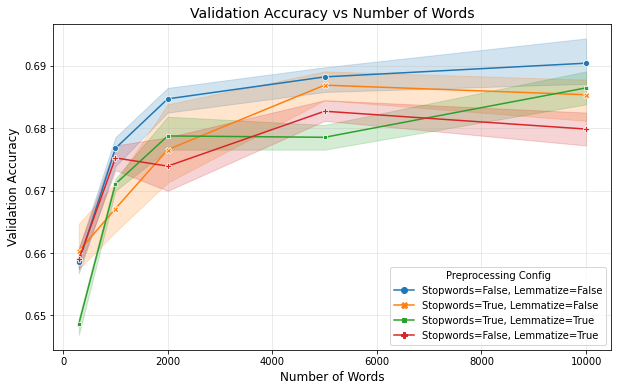

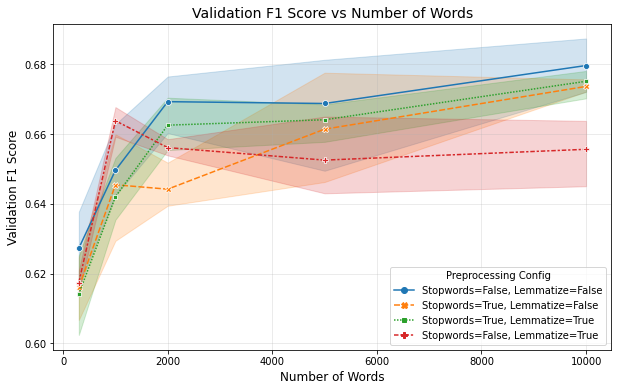

In [146]:
num_words_list = [300, 1000, 2000, 5000, 10000]
results = parameter_check(X_train_all,y_train_all, num_words_list, balance_classes=False, show_results=False)

In [147]:
762/(31+71+595+55+762)

0.5033025099075297

(1 of 20) Stopwords: False, Lemmatize: False, Number of words: 300, Val accuracy: 0.6284, F1 score: 0.6146
(2 of 20) Stopwords: False, Lemmatize: True, Number of words: 300, Val accuracy: 0.6238, F1 score: 0.6214
(3 of 20) Stopwords: True, Lemmatize: False, Number of words: 300, Val accuracy: 0.6172, F1 score: 0.5783
(4 of 20) Stopwords: True, Lemmatize: True, Number of words: 300, Val accuracy: 0.6257, F1 score: 0.623
(5 of 20) Stopwords: False, Lemmatize: False, Number of words: 1000, Val accuracy: 0.6587, F1 score: 0.6595
(6 of 20) Stopwords: False, Lemmatize: True, Number of words: 1000, Val accuracy: 0.662, F1 score: 0.6638
(7 of 20) Stopwords: True, Lemmatize: False, Number of words: 1000, Val accuracy: 0.6521, F1 score: 0.6443
(8 of 20) Stopwords: True, Lemmatize: True, Number of words: 1000, Val accuracy: 0.6561, F1 score: 0.6517
(9 of 20) Stopwords: False, Lemmatize: False, Number of words: 2000, Val accuracy: 0.6693, F1 score: 0.6688
(10 of 20) Stopwords: False, Lemmatize: Tr

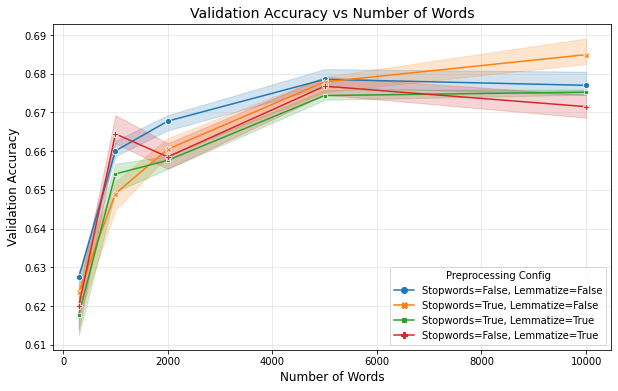

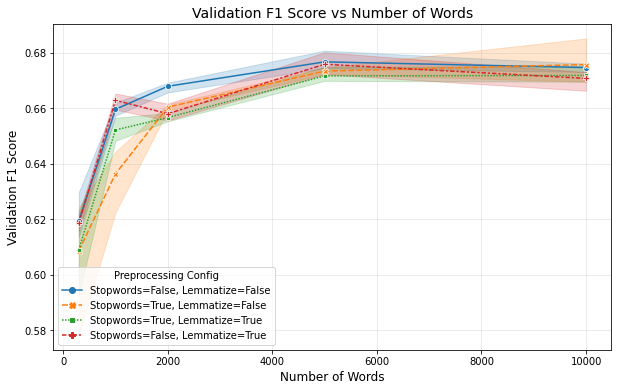

In [148]:
num_words_list = [300, 1000, 2000, 5000, 10000]
results = parameter_check(X_train_all,y_train_all, num_words_list, balance_classes=True, show_results=False)

In [149]:
y_val_all.value_counts()

No emotion toward brand or product    930
Positive emotion                      482
Negative emotion                      102
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64